In [46]:
import toy_data.cov_shift as data_gen
import toy_data as td
import bokeh.io
import numpy as np
import bokeh.plotting as bp
import bokeh.charts as bc
import tensorflow as tf
bokeh.io.output_notebook()

Loading BokehJS ...

In [47]:
# m_ = td.models.LinearBinary(2)
m_ = td.models.rotatedSine2D(phase=np.pi/2, frequency=1)
data = data_gen.Gaussian_Shift_2D_BinaryClassification(m_,
                                                       tst_X_mean_shift=(-3, -2.5),
                                                       noise_sd=0.4,
                                                       n_samples=400)
data_gen.visualize_2D_classification(data, classifyF=m_, fig_width=800)

### RBA

#### Density estimation using logistic regression
\begin{align}
    \frac{P(X_{\text{tr}})}{P(X_{\text{tst}})} = \frac{P(X\mid s=\text{tr})}{P(X\mid s=\text{tst})}
    &= \frac{\frac{P(s=\text{tr}\mid X)P(X)}{P(s=\text{tr})}}{\frac{P(s=\text{tst}\mid X)P(X)}{P(s=\text{tst})}} \\
    &= \frac{P(s=\text{tr}\mid X)P(s=\text{tst})}{P(s=\text{tst}\mid X)P(s=\text{tr})} \\
    &= \frac{P(s=\text{tst})}{P(s=\text{tr})}\frac{1-P(s=\text{tst}\mid X)}{P(s=\text{tst}\mid X)} \\
    &= \frac{P(s=\text{tst})}{P(s=\text{tr})}(\frac{1}{P(s=\text{tst}\mid X)} - 1)
\end{align}

Hence we can find $P(s=\text{tst}\mid X)$ first and then calculate the ratio from it
\begin{align}
\text{minimize}_{w} -\log p(s=\text{tst}\mid x; w),
\end{align}
which is logistic regression on $x, s$

We just reuse the previous LR model here:

In [48]:
tr = data.tr
tst = data.tst

In [49]:
n_tr = tr.y.shape[0]
n_tst = tst.y.shape[0]

x = tf.placeholder(tf.float32, [None, 2])
W = tf.Variable(tf.random_uniform(shape=[2, 1]), dtype=tf.float32)
b = tf.Variable(tf.random_uniform(shape=[1]), dtype=tf.float32)
logits = tf.matmul(x, W) + b
y = tf.nn.sigmoid(logits)
y_ = tf.placeholder(tf.float32, [None, 1])

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y_)
# loss = tf.reduce_mean(cross_entropy + tf.nn.l2_loss(W))
loss = tf.reduce_mean(cross_entropy)
# train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step = tf.train.RMSPropOptimizer(0.01).minimize(cross_entropy)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

s = np.concatenate((np.zeros(n_tr), np.ones(n_tst))).reshape(-1, 1)

for i in range(1000):
    sess.run(train_step, feed_dict={x: np.vstack((tr.X, tst.X)), y_: s})
    
correct_prediction = tf.equal(y > 0.5, y_>0.5)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(loss, feed_dict={x: np.vstack((tr.X, tst.X)), y_: s}))
print(sess.run(accuracy, feed_dict={x: np.vstack((tr.X, tst.X)), y_: s}))

def logi_classify_F(X):
    return sess.run(y, feed_dict={x: X})

data_gen.visualize_2D_classification(data, classifyF=logi_classify_F, fig_width=400)

0.159237
0.94


* The the ratio is: 
\begin{align}
    &\frac{P(s=\text{tst})}{P(s=\text{tr})}(\frac{1}{P(s=\text{tst}\mid X)} - 1) \\
    &=\frac{P(s=\text{tst})}{P(s=\text{tr})}(\frac{1}{\text{sigmoid}(-wX)} - 1) \\
    &=\frac{P(s=\text{tst})}{P(s=\text{tr})}e^{-wX}
\end{align}

In [50]:
def logi_reweight_F(X):
    _R = sess.run(n_tst/n_tr*(tf.exp(logits)), feed_dict={x: X})
    # _R = sess.run(n_tst/n_tr*(tf.exp(-logits)), feed_dict={x: X})
    return _R
z = np.array([[-2,2]]).T.T
logi_reweight_F(z)

array([[ 0.00154083]], dtype=float32)

In [151]:
def mixed_moments(_l, order):
    if order == 1:
        return _l
    r = (_l[:,[i]] * mixed_moments(_l[:,i:], order - 1) for i in range(_l.shape[1]))
    return np.hstack(r)
def mixed_moments_tf(_t, order):
    if order == 1:
        return _t
    n_vars = _t.get_shape()[1]
    r = [tf.expand_dims(_t[:, i], axis=1) * mixed_moments_tf(_t[:,i:], order-1) for i in range(n_vars)]
    return tf.concat(r, axis=1)
def get_moments(_x, order):
    # The hack by https://github.com/tensorflow/tensorflow/issues/956
    _t = tf.pad(_x - 1, [[0,0],[1,0]], 'CONSTANT') + 1
    return mixed_moments_tf(_t, order)
    
var_x = tf.Variable(tr.X)
moment_x = get_moments(var_x, 3)
with tf.Session() as _sess:
    _sess.run(var_x.initializer)
    momentx = _sess.run(moment_x)

[[  1.00000000e+00   3.68335089e+00   2.49973655e-01 ...,   3.39141103e+00
    2.30160915e-01   1.56200609e-02]
 [  1.00000000e+00   1.12136789e-01  -1.53735775e+00 ...,  -1.93317501e-02
    2.65031808e-01  -3.63349717e+00]
 [  1.00000000e+00  -9.18571633e-02   2.40447170e+00 ...,   2.02883033e-02
   -5.31070735e-01   1.39014151e+01]
 ..., 
 [  1.00000000e+00   2.48432284e+00  -1.47266210e+00 ...,  -9.08906428e+00
    5.38783459e+00  -3.19381189e+00]
 [  1.00000000e+00  -2.79066885e+00  -1.73873914e-01 ...,  -1.35410094e+00
   -8.43678857e-02  -5.25658016e-03]
 [  1.00000000e+00  -2.48914239e+00   5.23677387e-01 ...,   3.24461598e+00
   -6.82617444e-01   1.43612242e-01]]
[[  1.00000000e+00   3.68335089e+00   2.49973655e-01 ...,   3.39141103e+00
    2.30160915e-01   1.56200609e-02]
 [  1.00000000e+00   1.12136789e-01  -1.53735775e+00 ...,  -1.93317501e-02
    2.65031808e-01  -3.63349717e+00]
 [  1.00000000e+00  -9.18571633e-02   2.40447170e+00 ...,   2.02883033e-02
   -5.31070735e-01   

3.8267999880048365e-14

In [147]:
n_classes = 2
ys = np.eye(n_classes)

In [53]:
tr_y_1hot = np.hstack((tr.y, 1 - tr.y))
m_tr = get_moments(tr.X, 1).T
m_tr = m_tr[:, :, np.newaxis, np.newaxis]
# tr_y_1hot.shape
tr_y_1hot_4D = tr_y_1hot[:, np.newaxis, :, np.newaxis]
m_tr.shape

(320, 10, 1, 1)

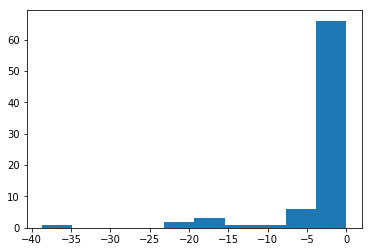

In [54]:
import matplotlib.pyplot as plt
plt.hist(-1/logi_reweight_F(data.tst.X))
plt.show()

In [55]:
min_eps = 0.0001
max_iter = 10000
lr = 0.0001
l_theta = 0.5
theta = np.zeros((10, n_classes))

In [56]:
def softmax(x, max_dim):
    e_x = np.exp(x - np.max(x, axis=max_dim, keepdims=True))
    return e_x / e_x.sum(axis=max_dim, keepdims=True)

def RBA_predict(x, theta):
    m = get_moments(x, 1).T
    m_d = m[:,:, np.newaxis, np.newaxis]*ys[np.newaxis, np.newaxis, :, :]
    # m_d.shape = (n_data, n_moments, n_classes, n_classes)
    pm_c = -1/logi_reweight_F(x)[:, :, np.newaxis, np.newaxis]*m_d*theta[np.newaxis, :, :, np.newaxis]
    p_c = np.sum(pm_c, axis=1, keepdims=True)
    return softmax(p_c, 3)

m_all = get_moments(data.X, 1).T
m_d_all = m_all[:,:, np.newaxis, np.newaxis]*ys[np.newaxis, np.newaxis, :, :]
reweight_all = logi_reweight_F(data.X)
def RBA_predict_all(theta):
    pm_c = -1/reweight_all[:, :, np.newaxis, np.newaxis]*m_d_all*theta[np.newaxis, :, :, np.newaxis]
    p_c = np.sum(pm_c, axis=1, keepdims=True)
    return softmax(p_c, 3)
    
def E(_m, _p):
    _Em = np.mean(_m*_p, axis=0)
    return np.sum(_Em, axis=2)

E_m_tr = E(m_tr, tr_y_1hot_4D)
    
_iter = 0
while True:
    _iter += 1
    pred = RBA_predict_all(theta) 
    dL = E_m_tr - E(m_d_all, pred)
    regular_grad = 2*theta/(np.linalg.norm(theta.ravel()) + 1e-9)
    theta_inc = dL + l_theta*regular_grad
    theta -= lr * theta_inc
    eps = np.linalg.norm(theta_inc)
    if not (_iter % 1000): # and _iter % 1001 and _iter % 1002):
        print(eps, np.linalg.norm(theta.ravel()))
        # print(theta.T)
        # print(l_theta*regular_grad.T)
    if eps < min_eps or _iter >= max_iter: 
        break

1.28141329014 0.193215180298
0.963090619519 0.299807172456
0.816176745168 0.384969706563
0.730676461198 0.459158772167
0.669735271353 0.526288277083
0.631046167804 0.588601319132
0.597335416497 0.647357477916
0.567987928567 0.703295806892
0.545740380213 0.756841163025
0.525501152991 0.808457814335


In [57]:
def RBA_F(x):
    pred = RBA_predict(x, theta)
    np.set_printoptions(precision=2, suppress=True)
    print(pred[0:5,0,:,:])
    np.set_printoptions(precision=8, suppress=False)
    print(pred.shape)
    return pred[:, 0, 0, 0]
data_gen.visualize_2D_classification(data, classifyF=RBA_F, fig_width=600)

[[[ 0.47  0.53]
  [ 0.51  0.49]]

 [[ 0.47  0.53]
  [ 0.51  0.49]]

 [[ 0.47  0.53]
  [ 0.51  0.49]]

 [[ 0.46  0.54]
  [ 0.51  0.49]]

 [[ 0.46  0.54]
  [ 0.51  0.49]]]
(22500, 1, 2, 2)
